---
title: Head Coaches 
description: Exploratory data analysis of the head coaches dataset
---

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from utils.plotting import *

### Loading data

In [2]:
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['Appointed', 'EndDate'])

### General information about data

In [3]:
long_tenure = head_coach[head_coach['Tenure'] > 3000].shape[0]
# head_coach = head_coach[head_coach['Tenure'] <= 3000]

We will exclude head coaches with more than 3000 days in post. There are {eval}`long_tenure` head coaches with more than 3000 days in post.

To-Do : Explain that those are outliers

### Basic plots

In [4]:
# Useful to add xtick months to dayofyear plot
months = pd.date_range('2022-01-01', '2022-12-31', freq='ME').strftime('%b').tolist()

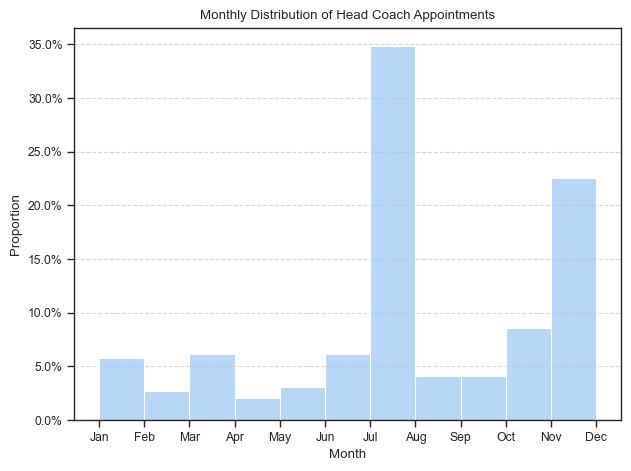

In [5]:
#| label: hc_appointment
plt.figure()
sns.histplot(head_coach['Appointed'].dt.month, bins=11, color = 'b', kde=False, stat='density')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xticks(range(1, 13), months)
plt.title('Monthly Distribution of Head Coach Appointments')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/hc_appointment.png')

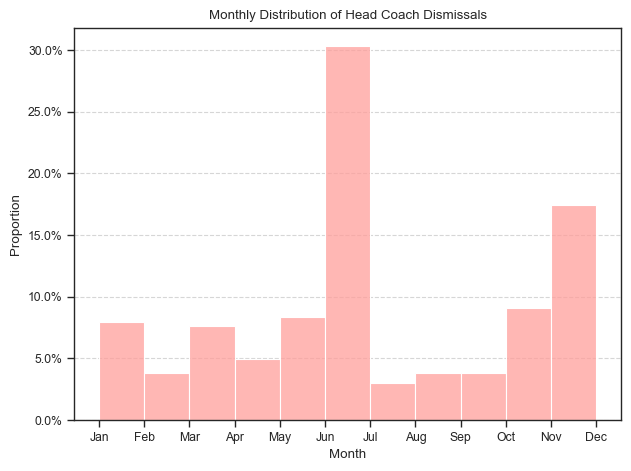

In [6]:
#| label: hc_dismissal
# Plot for Head Coach dismissal distribution
plt.figure()
sns.histplot(head_coach['EndDate'].dt.month, bins=11, color = 'r', kde=False, stat='density')
plt.xticks(range(1, 13), months)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title('Monthly Distribution of Head Coach Dismissals')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/hc_dismissal.png')

In [7]:
head_coach_dismissed = head_coach[head_coach['EndDate'].notnull()]

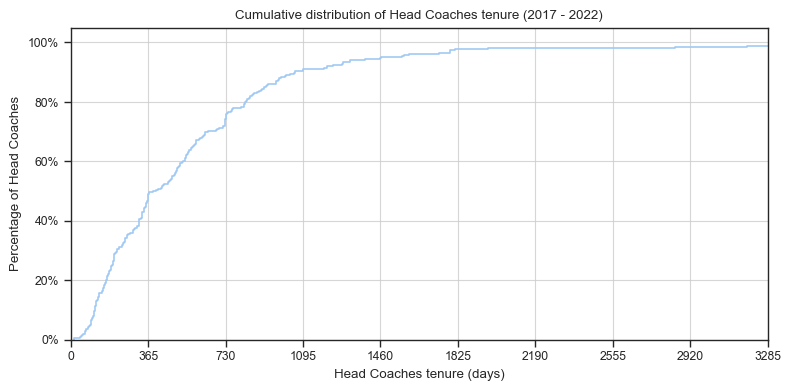

In [8]:
#| label: hc_tenure
# Plot ECDF of head_coach tenure 
plt.figure(figsize=(8, 4))

sns.ecdfplot(data=head_coach_dismissed, x='Tenure', stat = 'percent')
plt.ylabel('Percentage of Head Coaches')
# Format percentage
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
# Grid
plt.grid(axis='y', linestyle='-', alpha=0.8)
plt.grid(axis='x', linestyle='-', alpha=0.8)
plt.xticks(range(0, max(head_coach_dismissed['Tenure']) + 365, 365))
plt.xlim(0, head_coach_dismissed['Tenure'].quantile(0.99))
plt.title('Cumulative distribution of Head Coaches tenure (2017 - 2022)')
plt.xlabel('Head Coaches tenure (days)');
# plt.savefig('figures/hc_tenure.png')

En moyenne, les coachs sont restés en poste {eval}`round(head_coach_dismissed['Tenure'].mean())` jours.

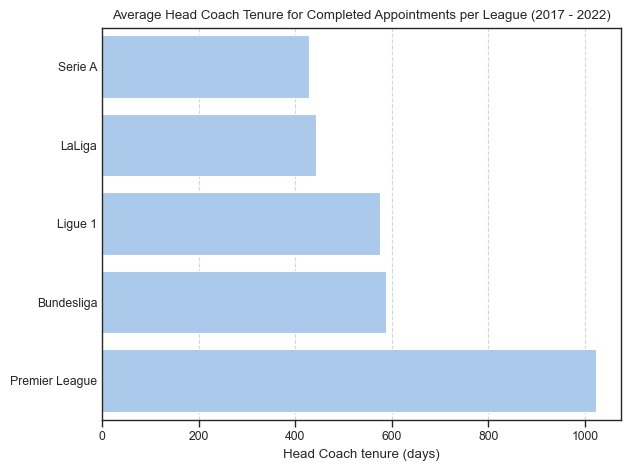

In [9]:
#| label: hc_tenure_per_league
# Average days in post per league 

# Calculate average days in post per league
avg_days_in_post = head_coach_dismissed.groupby('League')['Tenure'].mean()
avg_days_in_post = avg_days_in_post.sort_values()

# Plot average days in post per league
plt.figure()
sns.barplot(y=avg_days_in_post.index, x=avg_days_in_post.values, orient='h')
plt.title('Average Head Coach Tenure for Completed Appointments per League (2017 - 2022)')
plt.xlabel('Head Coach tenure (days)')
plt.tick_params(axis='y', which='both', length=0)
# Disable ylabel
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.8)

# plt.savefig('figures/hc_tenure_per_league.png')

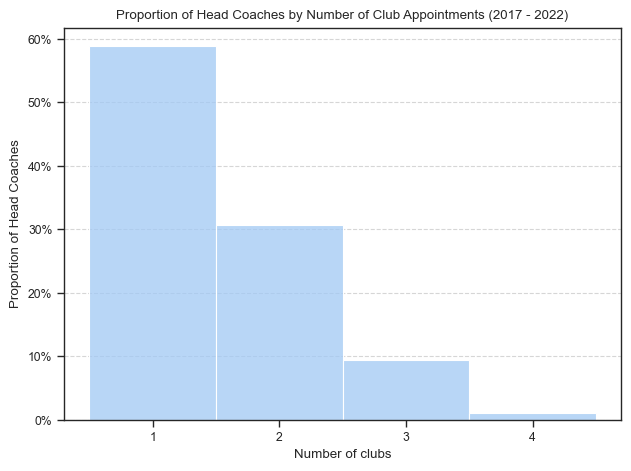

In [10]:
#| label: club_per_hc
# Number of clubs per Head Coach

# Group by coach_name and count the number of clubs
club_per_coach = head_coach.groupby('HeadCoach').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = club_per_coach, discrete = True, stat="probability")
plt.xticks(range(1, club_per_coach['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title('Proportion of Head Coaches by Number of Club Appointments (2017 - 2022)')
plt.xlabel('Number of clubs')
plt.ylabel('Proportion of Head Coaches')
plt.grid(axis='y', linestyle='--', alpha=0.8)
# plt.savefig('figures/number_of_club_per_coach.png')

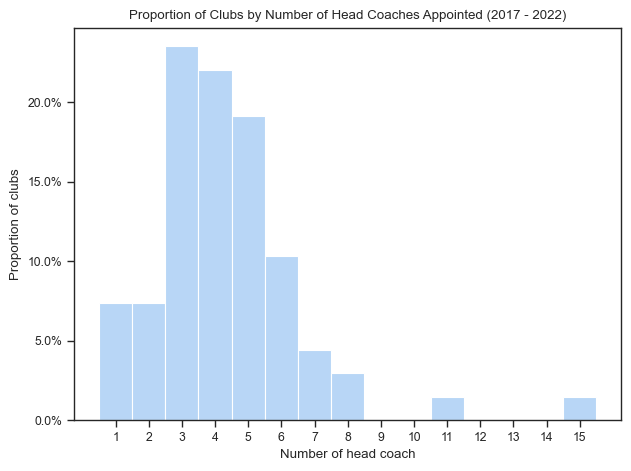

In [11]:
#| label: hc_per_club
# Number of Head Coachs per club

# Group by team and count the number of head coach
from re import M


coach_per_club = head_coach.groupby('Team').size().reset_index(name='count')

plt.figure()
sns.histplot(x='count', data = coach_per_club, discrete=True, stat="probability")
plt.xticks(range(1, coach_per_club['count'].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title(f'Proportion of Clubs by Number of Head Coaches Appointed (2017 - 2022)')
plt.xlabel('Number of head coach')
plt.ylabel('Proportion of clubs');
# plt.savefig('figures/number_of_coach_per_club.png')

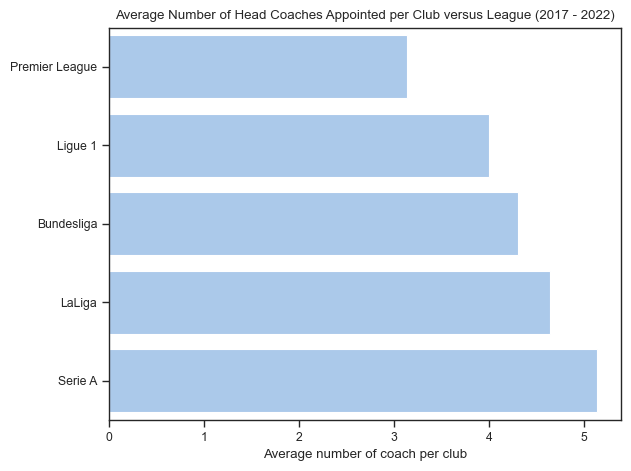

In [12]:
#| label: hc_per_club_per_league
# Average number of coach per club per league 

# Calculate average number of coach per club per league
coach_per_team = head_coach.groupby(['League', 'Team']).size()
avg_number_of_coach_per_club_per_league = coach_per_team.groupby('League').mean().sort_values()

# Plot average number of coach per club per league
plt.figure()
sns.barplot(x=avg_number_of_coach_per_club_per_league.values, y=avg_number_of_coach_per_club_per_league.index, orient='h')
plt.title('Average Number of Head Coaches Appointed per Club versus League (2017 - 2022)')
plt.ylabel('')
plt.xlabel('Average number of coach per club');
# plt.savefig('figures/hc_per_club_per_league.png')